# Titanic survival prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns; sns.set()  # for plot styling
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [69]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
df['Sex'].value_counts(sort=True, ascending=False)
df['Age'].value_counts(sort=True, ascending=False)
df['Fare'].value_counts(sort=True, ascending=False)

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
# check which columns to drop
df['Cabin'].unique()
df['Cabin'].value_counts(sort=True, ascending=False) 

Out of a total 891 passangers, only 147 have labelled cabins, and only four or five have more than 3 passangers allocated to them. I'm dropping this variable as it seems to lack informational content.

In [ ]:
df['Embarked'].value_counts(sort=True, ascending=True) 
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

Adding the three groups Q=77, C=168, S=644 gives out a total of 889 out of the data frame total 891 passengers. I'll perhaps delete the two samples that have nan.

### 2. Editing pandas df

In [73]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

KeyError: "['PassengerId' 'Name' 'Ticket' 'Cabin'] not found in axis"

#### 2.1 Convert object data into numerical data. In this case: Sex and Embarked

In [79]:
# this will transform multi-class worded variables into numerical groups (0, 1, 2, etc.)
object_array = (df.dtypes=='object')
object_cols = list(object_array[object_array].index)
print(object_cols)

encoder=LabelEncoder()
for cols in object_cols:
    df[cols]=encoder.fit_transform(df[cols]) 

['Sex', 'Embarked']


In [75]:
# this will transform multi-class worded variables into numerical groups (0, 1, 2, etc.)
object_array = (df_test.dtypes=='object')
object_cols = list(object_array[object_array].index)
print(object_cols)

encoder=LabelEncoder()
for cols in object_cols:
    df_test[cols]=encoder.fit_transform(df_test[cols]) 

[]


In [80]:
df.head()

#### 2.2 Deleting the samples with 'nan' in Embarked

In [58]:
df.head()
df['Embarked'].unique()
df['Embarked'].value_counts(sort=True, ascending=True) 
idx
df.loc[idx]
df.drop([61], axis = 0, inplace = True)
df.drop([829], axis = 0, inplace = True)

KeyError: '[61] not found in axis'

#### 2.3 Clean from nans

In [81]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


clean_dataset(df)
clean_dataset(df_test)

##### 2.4 Round the number of decimals

In [82]:
df.round(2)
df_test.round(2)

### 3. Evaluate features

<AxesSubplot:>

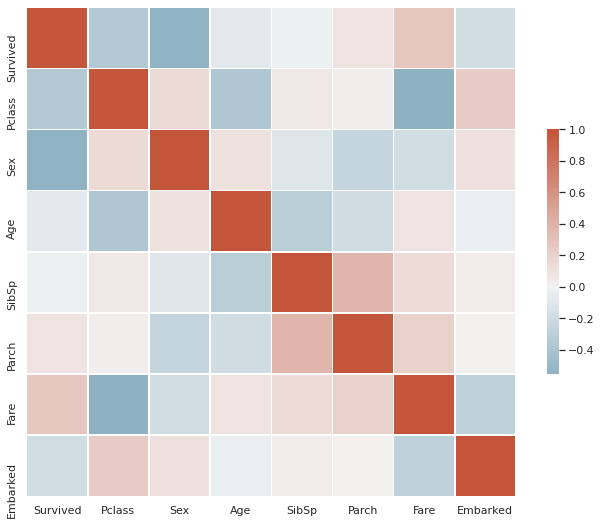

In [61]:
corr = df.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

A few notes:
- LabelEncoder labelled 'male' as 1 and 'female' as 0, simply because there were more male elements. The negative correlation hints that women were perhaps prioritised.
- Same thing for passenger class: Since there were fewer priority class passenger, these have been given lower-value labels. Again, it hints that higher class passengers were probably prioritised.
- Fare has a similar correlation (but positive) than passenger class.
- It seems like age didn't matter than much.

In [62]:
corr # checking numerical values

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.356462,-0.536762,-0.082446,-0.015523,0.095265,0.266100,-0.181979
Pclass,-0.356462,1.000000,0.150826,-0.365902,0.065187,0.023666,-0.552893,0.244145
Sex,-0.536762,0.150826,1.000000,0.099037,-0.106296,-0.249543,-0.182457,0.109639
Age,-0.082446,-0.365902,0.099037,1.000000,-0.307351,-0.187896,0.093143,-0.032565
SibSp,-0.015523,0.065187,-0.106296,-0.307351,1.000000,0.383338,0.139860,0.033064
Parch,0.095265,0.023666,-0.249543,-0.187896,0.383338,1.000000,0.206624,0.011803
Fare,0.266100,-0.552893,-0.182457,0.093143,0.139860,0.206624,1.000000,-0.283510
Embarked,-0.181979,0.244145,0.109639,-0.032565,0.033064,0.011803,-0.283510,1.000000


### 4. Run model

This is now a simple binary classification problem. I will use Logistic Regression first, then I might try a combination of different models (Random Forest Classifier, SVM, maybe Naive Bayes??).

In [89]:
y = df['Survived'].to_numpy()
X, X_test = df, df_test
X.drop(['Survived'], axis = 1, inplace = False)
X, X_test = X.to_numpy(), X_test.to_numpy()

In [106]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.6)

In [96]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [104]:
y_pred = model.predict(X_cv)
y_pred.shape
y_cv.shape

(356,)

In [105]:
accuracy_score(y_cv, y_pred)

1.0

In [101]:
model.score(y_cv, y_pred)

ValueError: Expected 2D array, got 1D array instead:
array=[0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1
 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 0
 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1
 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0
 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1
 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

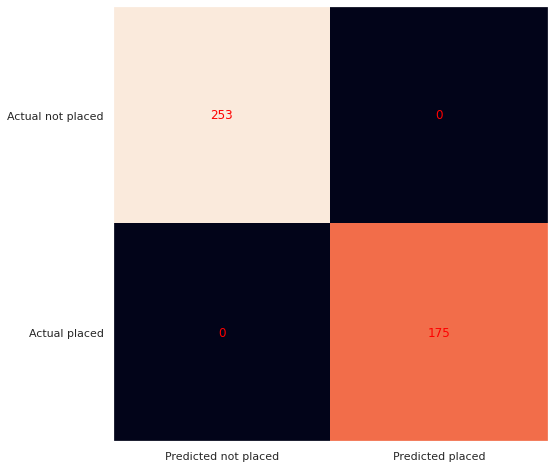

In [107]:
cm = confusion_matrix(y_cv, model.predict(X_cv))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted not placed', 'Predicted placed'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual not placed', 'Actual placed'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=18cf4704-3790-49a3-8d94-41dc8f485b71' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>